## Import Packages and Set Directories¶

In [2]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
factor_dir = os.path.join(base_dir, 'data', 'processed', 'factors')
sample_dir = os.path.join(base_dir, 'data', 'processed', 'sample_stock')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read in Data

In [3]:
# Read the stock data into dataframes
price_1_file = os.path.join(data_dir, 'price_1.csv')
price_2_file = os.path.join(data_dir, 'price_2.csv')
price_3_file = os.path.join(data_dir, 'price_3.csv')
price_4_file = os.path.join(data_dir, 'price_4.csv')
df_1 = pd.read_csv(price_1_file, index_col='Date')
df_2 = pd.read_csv(price_2_file, index_col='Date')
df_3 = pd.read_csv(price_3_file, index_col='Date')
df_4 = pd.read_csv(price_4_file, index_col='Date')
bc_df = pd.read_csv(os.path.join(data_dir, 'business_cycle_divided.csv'))

# Read Business cycle data
bc_df['Year_Month'] = pd.to_datetime(bc_df['Year'].astype(str) + '-' + bc_df['Month'].astype(str))
bc_df['Year_Month'] = bc_df['Year_Month'].dt.to_period('M')
bc_df['Year_Month'] = bc_df['Year_Month'].astype('str')
bc_df.drop(columns=['Year', 'Month', 'Cof_idx', 'Recession'], inplace=True)

# Read factor data
factors_weekly_df = pd.read_csv(os.path.join(factor_dir, 'factors_weekly.csv'))
factors_monthly_df = pd.read_csv(os.path.join(factor_dir, 'factors_monthly.csv'))

Check the start date, end date, and the number of stocks in each dataframe.

In [3]:
# Iterate through each df and print start and end dates and number of stocks
dfs = [df_1, df_2, df_3, df_4]
for i, df in enumerate(dfs):
    start, end = df.index.min(), df.index.max()
    num_columns = df.shape[1]  # Number of columns
    print(f"Cycle {i+1} starts from {start}, ends with {end}, and has {num_columns} stocks.")

Cycle 1 starts from 1990-10-10, ends with 2001-09-21, and has 284 stocks.
Cycle 2 starts from 2001-09-20, ends with 2009-03-09, and has 663 stocks.
Cycle 3 starts from 2009-03-09, ends with 2020-03-23, and has 843 stocks.
Cycle 4 starts from 2020-03-23, ends with 2024-02-14, and has 1191 stocks.


## 1. Optimal Portfolios across Cycles¶

### 1.1 Construct Optimal Portfolios across Cycles¶

Since cycle 4 has the highest number of stocks, the inverse of the covariance matrix become more sensitive to high correlation stocks. Therefore, we have to set the correlation threshold lower to create optimized portfolio.

In [4]:
# Initialize OptimalPortfolios class
num_pfo = 5
corr_threshold = 0.99
ef1 = OptimalPortfolios(df_1, num_pfo, corr_threshold)
ef2 = OptimalPortfolios(df_2, num_pfo, corr_threshold)
ef3 = OptimalPortfolios(df_3, num_pfo, corr_threshold)
ef4 = OptimalPortfolios(df_4, num_pfo, corr_threshold**5)  # lower the threshold for optimization

# Calculate efficient frontier
ef_instances = [ef1, ef2, ef3, ef4]
for ef in ef_instances:    
    ef.calculate_efficient_frontier()

5 stocks removed, 279 stocks remain.
0 stocks removed, 663 stocks remain.
56 stocks removed, 787 stocks remain.
324 stocks removed, 867 stocks remain.


Combine the optimal portfolios from different cycles into a single dataset. Add a new column named 'Cycle' to indicate the specific cycle each portfolio belongs to. Then, save the daily, weekly, monthly, and yearly returns of these combined optimal portfolios into separate CSV files.

In [5]:
ef_combined_daily = ef1.daily_return.head(0).copy()
ef_combined_weekly = ef1.weekly_return.head(0).copy()
ef_combined_monthly = ef1.monthly_return.head(0).copy()
ef_combined_annual = ef1.annual_return.head(0).copy()

for idx, ef in enumerate(ef_instances):
    ef_daily = ef.daily_return.copy().reset_index()
    ef_weekly = ef.weekly_return.copy().reset_index()
    ef_monthly = ef.monthly_return.copy().reset_index()
    ef_annual = ef.annual_return.copy().reset_index()    
    ef_daily['Cycle'] = idx + 1
    ef_weekly['Cycle'] = idx + 1
    ef_monthly['Cycle'] = idx + 1
    ef_annual['Cycle'] = idx + 1
    # Combine the dataframes
    ef_combined_daily = pd.concat([ef_combined_daily, ef_daily]).drop_duplicates(subset='Date', keep='first')
    ef_combined_weekly = pd.concat([ef_combined_weekly, ef_weekly]).drop_duplicates(subset='Year_Week', keep='first')
    ef_combined_monthly = pd.concat([ef_combined_monthly, ef_monthly]).drop_duplicates(subset='Year_Month', keep='first')
    ef_combined_annual = pd.concat([ef_combined_annual, ef_annual]).drop_duplicates(subset='Date', keep='first')

# Change decimals into percentage
cols_to_multiply = ef_combined_daily.columns.difference(['Date', 'Cycle'])
ef_combined_daily[cols_to_multiply] = ef_combined_daily[cols_to_multiply] * 100
ef_combined_weekly[cols_to_multiply] = ef_combined_weekly[cols_to_multiply] * 100
ef_combined_monthly[cols_to_multiply] = ef_combined_monthly[cols_to_multiply] * 100
ef_combined_annual[cols_to_multiply] = ef_combined_annual[cols_to_multiply] * 100
    
# Set the index
ef_combined_daily.set_index('Date', inplace=True)
ef_combined_weekly.set_index('Year_Week', inplace=True)
ef_combined_monthly.set_index('Year_Month', inplace=True)
ef_combined_annual.set_index('Date', inplace=True)


Store to CSV files

In [6]:
daily_path = os.path.join(sample_dir, 'optimal_pfo_return_daily.csv')
weekly_path = os.path.join(sample_dir, 'optimal_pfo_return_weekly.csv')
monthly_path = os.path.join(sample_dir, 'optimal_pfo_return_monthly.csv')
yearly_path = os.path.join(sample_dir, 'optimal_pfo_return_yearly.csv')
# ef_combined_daily.to_csv(daily_path)
# ef_combined_weekly.to_csv(weekly_path)
# ef_combined_monthly.to_csv(monthly_path)
# ef_combined_annual.to_csv(yearly_path)

### 1.2 Visualization on the Optimal Portfolios 

From the line chart below, we can observe that the portfolios within each cycle follow the same monthly return trend. This outcome aligns with our objective of capturing the preferences of different types of investors. Additionally, it's noticeable that Portfolio 3, characterized by high risk and high return, typically experiences the greatest variability in monthly returns. This observation is in line with our expectations and further corroborates our findings from the efficient frontier analysis.

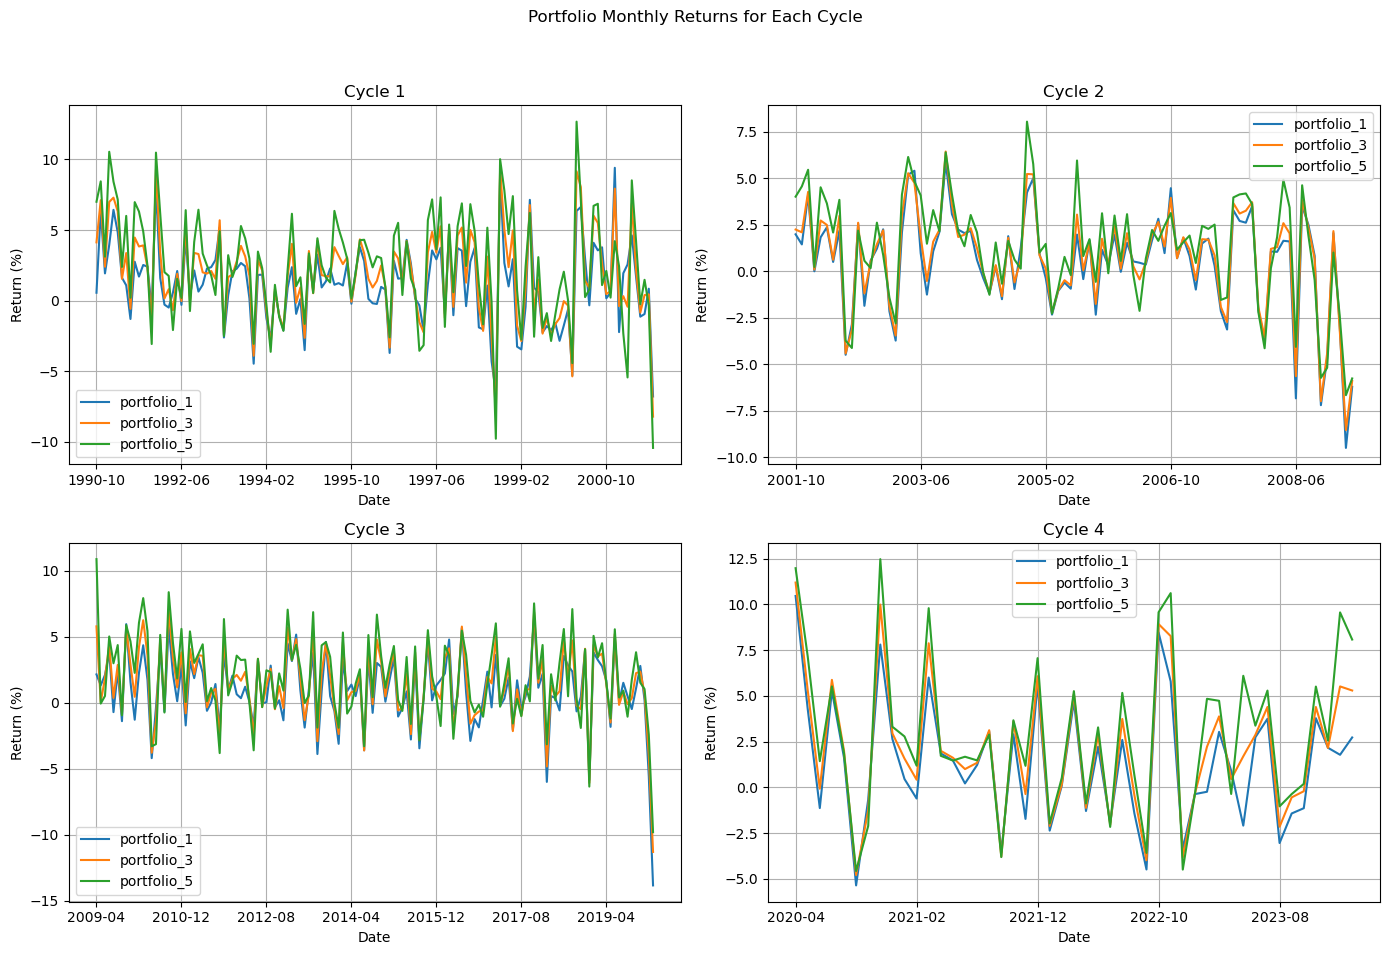

In [7]:
# Creating subplots for each cycle
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Portfolio Monthly Returns for Each Cycle')
cycles = ef_combined_monthly['Cycle'].unique()
for i, cycle in enumerate(cycles):
    ax = axes[i//2, i%2]
    cycle_data = ef_combined_monthly[ef_combined_monthly['Cycle'] == cycle]
    
    cycle_data[['portfolio_1', 'portfolio_3', 'portfolio_5']].plot(ax=ax)
    ax.set_title(f'Cycle {int(cycle)}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return (%)')
    ax.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
# plt.savefig(os.path.join(graph_dir, 'optimal_monthly_returns_cycles.png'))
plt.show()

We can create graphs to observe the number of stocks utilized in each portfolio. It is evident that most portfolios comprise approximately 30 to 70 stocks. This observation suggests that removing some highly correlated stocks might not significantly impact our analysis, as less than a quarter of the stocks are typically employed in these portfolios.

{'1990-2001': [64, 54, 34], '2001-2009': [32, 30, 28], '2009-2020': [38, 42, 35], '2020-2024': [47, 41, 33]}


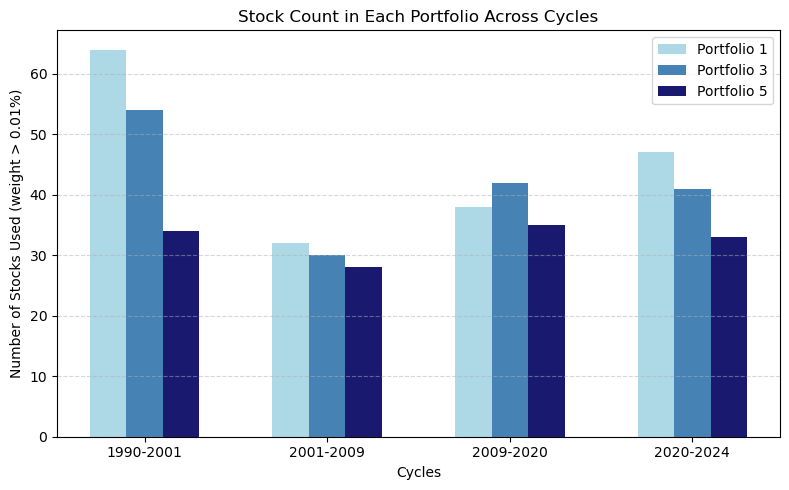

In [8]:
# Calculate number of stocks used for each portfolio
ticker_counts = {}
threshold = 1e-4
ef_names = ['1990-2001', '2001-2009', '2009-2020', '2020-2024']

# Loop through each instance and each portfolio
for ef_name, ef in zip(ef_names, ef_instances):    
    counts = []
    for i in range(1, num_pfo + 1, 2):
        count = len(ef.weight_df[abs(ef.weight_df[f'weight_{i}']) > threshold])
        counts.append(count)
    ticker_counts[ef_name] = counts
print(ticker_counts)

# Create a bar chart
fig, ax = plt.subplots(figsize=(8,5))
positions = range(len(ef_names))
width = 0.2
colors = ['lightblue', 'steelblue', 'midnightblue']
for i in range(3):
    pos = [p + width*i for p in positions]
    counts = [ticker_counts[ef_name][i] for ef_name in ef_names]
    ax.bar(pos, counts, width, label=f'Portfolio {2*i+1}', color=colors[i % len(colors)])

# Adding labels and title
ax.set_xlabel('Cycles')
ax.set_ylabel('Number of Stocks Used (weight > 0.01%)')
ax.set_title('Stock Count in Each Portfolio Across Cycles')
ax.set_xticks([p + width for p in range(len(ef_names))])
ax.set_xticklabels(ef_names)
ax.legend()
ax.yaxis.grid(True, alpha=0.5, linestyle='--')
# plt.savefig(os.path.join(graph_dir, 'optimal_portfolios_count.png'))
plt.tight_layout()
plt.show()

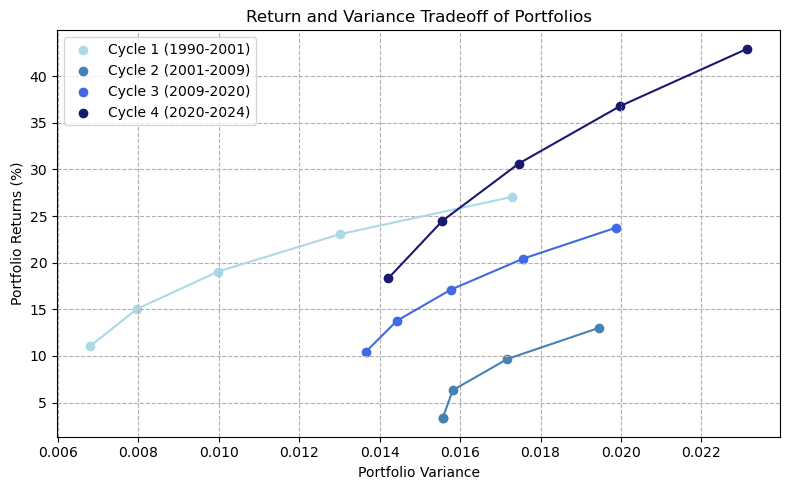

In [9]:
# Plotting for each portfolio
plt.figure(figsize=(8,5))
for ef, color, label in zip([ef1, ef2, ef3, ef4], ['lightblue', 'steelblue', 'royalblue', 'midnightblue'],
                            ['Cycle 1 (1990-2001)','Cycle 2 (2001-2009)','Cycle 3 (2009-2020)','Cycle 4 (2020-2024)']):
    pfo_vars = np.array(ef.pfo_vars)
    pfo_returns = np.array(ef.pfo_returns) * 100
    plt.scatter(pfo_vars, pfo_returns, color=color, label=label)
    plt.plot(pfo_vars, pfo_returns, color=color)

# Setting labels and title
plt.xlabel('Portfolio Variance')
plt.ylabel('Portfolio Returns (%)')
plt.title('Return and Variance Tradeoff of Portfolios')
plt.legend()
plt.grid(True, linestyle='--')

# Show and save the plot
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'optimal_portfolios_tradeoff.png'))
plt.show()

## 2. Optimal Portfolios under Different Economic Conditions

Under each of the four cycles, we can divde it into **Recovery**, **Expansion**, **Downturn**, and **Depression**. We will create different portfolios for each sub-cycle.

In [4]:
def create_week_column(df_orginal):
    """
    Create a Year_Week column using df's Date column and drop 'Date column'
    """
    df_tmp = df_orginal.copy()
    df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
    df_tmp['Week'] = df_tmp['Date'].dt.isocalendar().week  
    df_tmp['Year'] = df_tmp['Date'].dt.isocalendar().year
    df_tmp['Year_Week'] = df_tmp['Year'].astype(str) + '-' + df_tmp['Week'].astype(str).str.zfill(2)
    df_tmp.drop(columns=['Year', 'Week', 'Date'], inplace=True)
    return df_tmp


def create_phase_pfo(phase, bc_df, stock_dfs, factors_week, factors_month, num_pfo, corr_threshold):
    print(f"\n***{phase} Phase***")
    # Loop over stock_dfs
    for idx, stock_df in enumerate(stock_dfs):
        # Filter current phase data
        phase_df = stock_df.copy().reset_index()
        phase_df['Year_Month'] = pd.to_datetime(phase_df['Date']).dt.to_period('M')
        phase_df['Year_Month'] = phase_df['Year_Month'].astype('str')
        phase_df = pd.merge(phase_df, bc_df, how='inner', on='Year_Month')
        phase_df = phase_df[phase_df[phase] == 1].set_index('Date')
        # Remove phases and Year_Month columns
        cols_to_keep = stock_df.columns
        phase_df = phase_df[cols_to_keep]    
        # Consturct optimal portfolios for current phase
        ef_phase_stock = OptimalPortfolios(phase_df, num_pfo, corr_threshold)
        ef_phase_stock.calculate_efficient_frontier()

        # Extract return data from class
        ef_daily = ef_phase_stock.daily_return.reset_index()
        ef_weekly = ef_phase_stock.weekly_return.reset_index()
        ef_monthly = ef_phase_stock.monthly_return.reset_index()
        # Create header if starting 
        if idx == 0:
            ef_phase_daily = ef_daily.head(0)
            ef_phase_weekly = ef_weekly.head(0)
            ef_phase_monthly = ef_monthly.head(0)
        # Concat the dataframe and drop duplicates
        ef_phase_daily = pd.concat([ef_phase_daily, ef_daily]).drop_duplicates(subset='Date', keep='last')
        ef_phase_weekly = pd.concat([ef_phase_weekly, ef_weekly]).drop_duplicates(subset='Year_Week', keep='last')
        ef_phase_monthly = pd.concat([ef_phase_monthly, ef_monthly]).drop_duplicates(subset='Year_Month', keep='last')

    # Reset Index
    ef_phase_daily = ef_phase_daily.set_index('Date')
    ef_phase_weekly = ef_phase_weekly.set_index('Year_Week')
    ef_phase_monthly = ef_phase_monthly.set_index('Year_Month')

    # Change decimals into percentage
    ef_phase_daily = ef_phase_daily * 100
    ef_phase_weekly = ef_phase_weekly * 100
    ef_phase_monthly = ef_phase_monthly * 100

    # Add phase column
    ef_phase_daily['Phase'] = phase
    ef_phase_weekly['Phase'] = phase
    ef_phase_monthly['Phase'] = phase

    # Reset index to merge with factors
    ef_phase_daily = ef_phase_daily.reset_index()
    ef_phase_weekly = ef_phase_weekly.reset_index()
    ef_phase_monthly = ef_phase_monthly.reset_index()
    factors_weekly_tmp = create_week_column(factors_week)

    # Merge stock df with factor df
    covariates_weekly = pd.merge(ef_phase_weekly, factors_weekly_tmp, how='inner', on='Year_Week')
    covariates_monthly = pd.merge(ef_phase_monthly, factors_month, how='inner', on='Year_Month')

    # Calculate excess return
    pfo_col_names = []  # create tmp list to re-order columns
    for pfo in range(1, num_pfo+1):
        covariates_weekly[f'R{pfo}-RF'] = covariates_weekly[f'portfolio_{pfo}'] - covariates_weekly['RF']
        covariates_monthly[f'R{pfo}-RF'] = covariates_monthly[f'portfolio_{pfo}'] - covariates_monthly['RF']
        covariates_weekly.drop(columns=[f'portfolio_{pfo}'], inplace=True)   
        pfo_col_names.append(f'R{pfo}-RF')  # append the pfo name to list  

    # Reorder columns 
    cols_remaining = covariates_weekly.columns.difference(['Year_Week','Phase'] + pfo_col_names).tolist()
    covariates_weekly = covariates_weekly[['Phase', 'Year_Week'] +  pfo_col_names + cols_remaining]
    covariates_monthly = covariates_monthly[['Phase', 'Year_Month'] + pfo_col_names + cols_remaining]
    covariates_weekly.drop(columns=['RF'], inplace=True)  # drop RF column
    covariates_monthly.drop(columns=['RF'], inplace=True)  # drop RF column
    return covariates_weekly, covariates_monthly, ef_phase_daily

Create optimal portfolios for each phase

In [5]:
fw, fm = factors_weekly_df, factors_monthly_df
stock_dfs = [df_1, df_2, df_3, df_4]
recovery_w, recovery_m, recovery_d = create_phase_pfo('Recovery', bc_df, stock_dfs, fw, fm, 3, 0.98)
expansion_w, expansion_m, expansion_d = create_phase_pfo('Expansion', bc_df, stock_dfs, fw, fm, 3, 0.98)
downturn_w, downturn_m, downturn_d = create_phase_pfo('Downturn', bc_df, stock_dfs, fw, fm, 3, 0.98)
depression_w, depression_m, depression_d, = create_phase_pfo('Depression', bc_df, stock_dfs, fw, fm, 3, 0.98)


***Recovery Phase***
0 stocks removed, 284 stocks remain.
8 stocks removed, 655 stocks remain.
66 stocks removed, 777 stocks remain.
344 stocks removed, 847 stocks remain.

***Expansion Phase***
58 stocks removed, 226 stocks remain.
29 stocks removed, 634 stocks remain.
311 stocks removed, 532 stocks remain.
79 stocks removed, 1112 stocks remain.

***Downturn Phase***
49 stocks removed, 235 stocks remain.
96 stocks removed, 567 stocks remain.
248 stocks removed, 595 stocks remain.
19 stocks removed, 1172 stocks remain.

***Depression Phase***
197 stocks removed, 87 stocks remain.
36 stocks removed, 627 stocks remain.
674 stocks removed, 169 stocks remain.
275 stocks removed, 916 stocks remain.


Combine the dataframes and save to csv

In [12]:
# Combine monthly dfs
monthly_dfs = [recovery_m, expansion_m, downturn_m, depression_m]
combined_m = recovery_m.head(0)
for df in monthly_dfs:
    combined_m = pd.concat([combined_m, df])
combined_m.to_csv(os.path.join(data_dir, 'covariates_monthly_fixed.csv'), index=False)

# Combine weekly dfs
weekly_dfs = [recovery_w, expansion_w, downturn_w, depression_w]
combined_w = recovery_w.head(0)
for df in weekly_dfs:
    combined_w = pd.concat([combined_w, df])
combined_w.to_csv(os.path.join(data_dir, 'covariates_weekly_fixed.csv'), index=False)


# Combine daily dfs
daily_dfs = [recovery_d, expansion_d, downturn_d, depression_d]
combined_d = recovery_d.head(0)
for df in daily_dfs:
    combined_d = pd.concat([combined_d, df])


In [7]:
combined_m[combined_m['R1-RF']>20]

,Phase,Year_Month,R1-RF,R2-RF,R3-RF,CMA,CRD,EG,HML,IA,LIQ,ME,MOM,Mkt-RF,RMW,ROE,SMB


In [8]:
combined_d[combined_d['portfolio_1']>10]

,Date,portfolio_1,portfolio_2,portfolio_3,Phase


In [11]:
combined_w

,Phase,Year_Week,R1-RF,R2-RF,R3-RF,CMA,CRD,EG,HML,IA,LIQ,ME,MOM,Mkt-RF,RMW,ROE,SMB
0,Recovery,1991-14,0.064083,0.240037,0.486756,-0.570730,1.150221,-0.5419,-0.869560,-0.2831,1.472018,1.9119,0.891933,0.513137,-0.032457,0.4557,1.521326
1,Recovery,1991-15,0.264305,0.625699,0.993622,0.621385,2.298820,0.2974,0.269460,0.7554,1.155684,-0.6018,0.530151,1.069284,-0.160184,1.1641,-0.205230
2,Recovery,1991-16,0.397411,0.907257,1.589490,0.369853,-0.318141,0.1628,1.181054,0.0403,0.726344,-0.6797,-2.540450,0.823179,0.438583,-0.9019,-0.383025
3,Recovery,1991-17,-0.461241,-0.400725,-0.402482,-0.120218,-1.594360,0.7819,0.109392,-0.2596,-1.943223,-0.6371,-0.758405,-1.507046,0.410131,0.1809,-0.043628
4,Recovery,1991-18,0.821113,1.524843,2.275011,0.149088,-0.747710,-0.9039,0.358368,0.0811,-1.789523,-0.6211,0.498412,0.284198,0.149900,0.3691,-0.427979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,Depression,2023-13,3.841668,4.027187,4.204946,-0.485292,-1.407705,-1.4244,-0.143893,-0.2634,1.732601,0.2691,-0.973392,3.558954,-1.316858,-0.8488,0.034930
283,Depression,2023-14,-0.953973,-1.217425,-1.492620,1.735561,-1.614857,0.5352,0.917433,1.4937,-1.772066,-2.3515,-0.320548,-0.503105,0.888682,-0.5042,-2.343848
284,Depression,2023-15,0.587449,1.277355,1.856163,-0.173153,1.298617,-0.7802,0.240468,-0.3454,0.917606,1.2397,1.088540,0.902690,0.870444,0.6098,0.521296
285,Depression,2023-16,0.199820,0.414522,0.610869,0.429173,1.073625,-0.5350,-1.267848,0.8561,-0.700302,0.3524,1.692891,-0.202255,-1.235283,-1.8503,0.769253
